<a href="https://colab.research.google.com/github/eternal-spring/ml-course/blob/main/homeworks/task03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ✅ Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- ✅ Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- ✅ Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- ✅ Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- ✅ При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- ✅ Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- ✅ Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- ✅ Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- ✅ \* (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- ✅ \* (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Реализуем логистическую регрессию с $L_2$-регуляризацией.

Будем минимизировать функционал $L = - \sum_{i=1}^m \left( y_i \ln(\hat{y}_i) + (1 - y_i) \ln(1 - \hat{y}_i) \right) + \frac{\lambda}{2} \sum_{j=1}^n w_j^2 ,$
где $\hat{y}_i = \frac{1}{1 + e^{-z_i}}, \ z_i = \sum_{j=1}^n w_j x_{ij} + b
$
с помощью градиентного спуска.

$$\frac{\partial L}{\partial w_j} = \sum_{i=1}^m (\hat{y}_i - y_i) x_{ij}+ \lambda w_j$$

$$w_j := w_j - \alpha \frac{\partial L}{\partial w_j}$$

$\alpha, λ$ $-$ гиперпараметры


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils import check_X_y, check_array

class MyOwnLogisticRegression(ClassifierMixin, BaseEstimator):
  def __init__(self, alpha=1.0, lam=1.0):
    self.alpha = alpha
    self.lam = lam

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

  def fit(self, X, y):
    self.classes_ = np.unique(y)
    n, d = X.shape
    X, y = check_X_y(X, y, y_numeric=True)
    weights = np.zeros(d + 1)
    X_sample = np.column_stack([np.ones(n), X])
    k = 1
    lambda_weights = np.hstack(([0], np.ones(d) * self.lam))
    while k <= 10000:
      predictions = 1 / (1 + np.exp(-X_sample @ weights))
      gradient = X_sample.T @ (predictions - y) + lambda_weights * weights
      diff = self.alpha * gradient
      weights -= diff
      if np.linalg.norm(diff) <= 10**-4:
        break
      k += 1
    self.weights = weights
    return self

  def predict_proba(self, X):
    X_sample = np.column_stack([np.ones(X.shape[0]), X])
    return 1 / (1 + np.exp(-X_sample @ self.weights))

  def predict(self, X):
    return self.predict_proba(X).round()

Также реализуем метод $k$ ближайших соседей, $\ k$ и метрика $p$ $-$ гиперпараметры

In [ ]:
from scipy.spatial.distance import cdist
class MyOwnKNeighbors(ClassifierMixin, BaseEstimator):
  def __init__(self, k=5, p=2):
    self.k = k
    self.p = p

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

  def fit(self, X, y):
    X, y = check_X_y(X, y, y_numeric=True)
    self.classes_ = np.unique(y)
    self._X = X.astype(np.float32)
    self._y = y
    return self

  def predict(self, X):
    X = check_array(X).astype(np.float32)
    distances = cdist(X, self._X, metric='minkowski', p=self.p)
    k_nearest_labels = self._get_k_nearest_labels(distances)
    predictions = [Counter(labels).most_common(1)[0][0] for labels in k_nearest_labels]
    return np.array(predictions)

  def _get_k_nearest_labels(self, distances):
    k_indices = np.argsort(distances, axis=1)[:, :self.k]
    k_nearest_labels = self._y[k_indices]
    return k_nearest_labels

#Heart disease

Описание датасета:

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type (4 values)
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results (values 0,1,2)
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 1 = normal; 2 = fixed defect; 3 = reversable defect
* target - have disease or not (1=yes, 0=no)

In [ ]:
df = pd.read_csv('/content/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Удалим дубликаты

In [ ]:
df[df.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
15,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
31,50,0,1,120,244,0,1,162,0,1.1,2,0,2,1
43,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
55,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
61,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [ ]:
df.drop(df[df.duplicated()].index, inplace=True)

In [ ]:
pd.set_option('display.max_columns', 40)
%precision %8.8g
# df = df.round(decimals=0)
df.describe(include='all').apply(lambda s: s.apply(lambda x: format(x, '.7g')))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302,302,302,302,302,302,302,302,302,302,302,302,302,302
mean,54.42053,0.6821192,0.9635762,131.6026,246.5,0.1490066,0.5264901,149.5695,0.3278146,1.043046,1.397351,0.718543,2.31457,0.5430464
std,9.04797,0.4664257,1.032044,17.56339,51.75349,0.356686,0.5260272,22.90353,0.470196,1.161452,0.616274,1.006748,0.6130255,0.4989704
min,29,0,0,94,126,0,0,71,0,0,0,0,0,0
25%,48,0,0,120,211,0,0,133.25,0,0,1,0,2,0
50%,55.5,1,1,130,240.5,0,1,152.5,0,0.8,1,0,2,1
75%,61,1,2,140,274.75,0,1,166,1,1.6,2,1,3,1
max,77,1,3,200,564,1,2,202,1,6.2,2,4,3,1


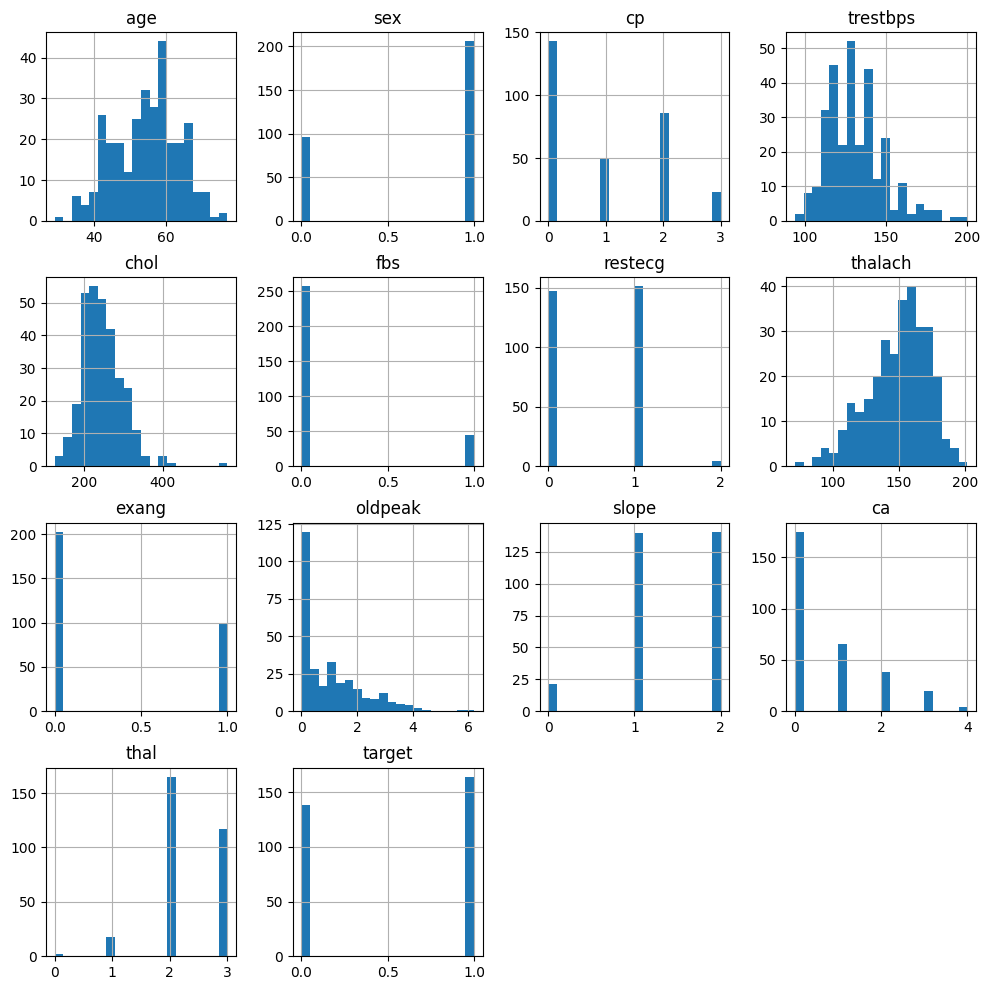

In [ ]:
df.hist(bins = 20, figsize = (12,12))
plt.show()

thal может принимать значения 1, 2, 3, удалим строки, где thal = 0

In [ ]:
df[df.thal == 0]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
14,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0
319,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1


In [ ]:
df.drop(df[df.thal == 0].index, inplace=True)

In [ ]:
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df[categorical] = df[categorical].astype(object)

In [ ]:
numerical_col = df.select_dtypes(exclude=np.object_)
categorical_col = df.select_dtypes(exclude=np.number)

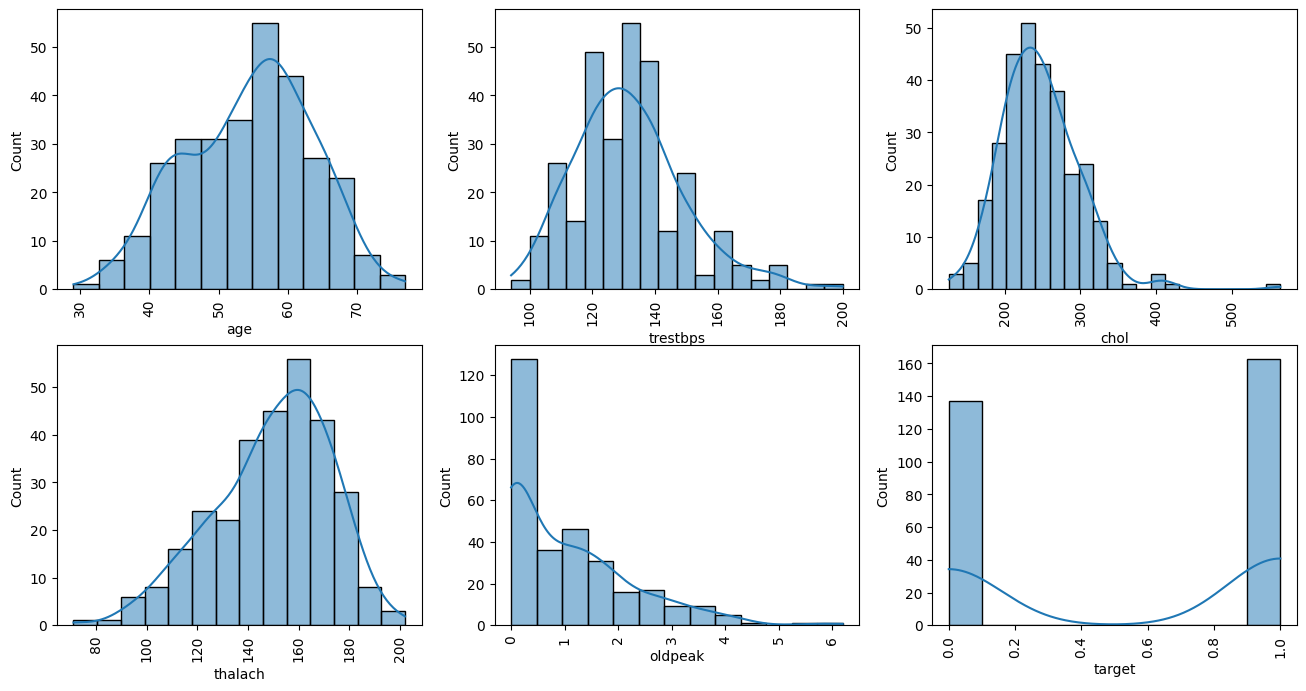

In [ ]:
plt.figure(figsize=(16,8))
for index, column in enumerate(numerical_col):
    plt.subplot(2, 3, index + 1)
    sns.histplot(data=numerical_col, x=column,kde=True)
    plt.xticks(rotation = 90)
plt.show()

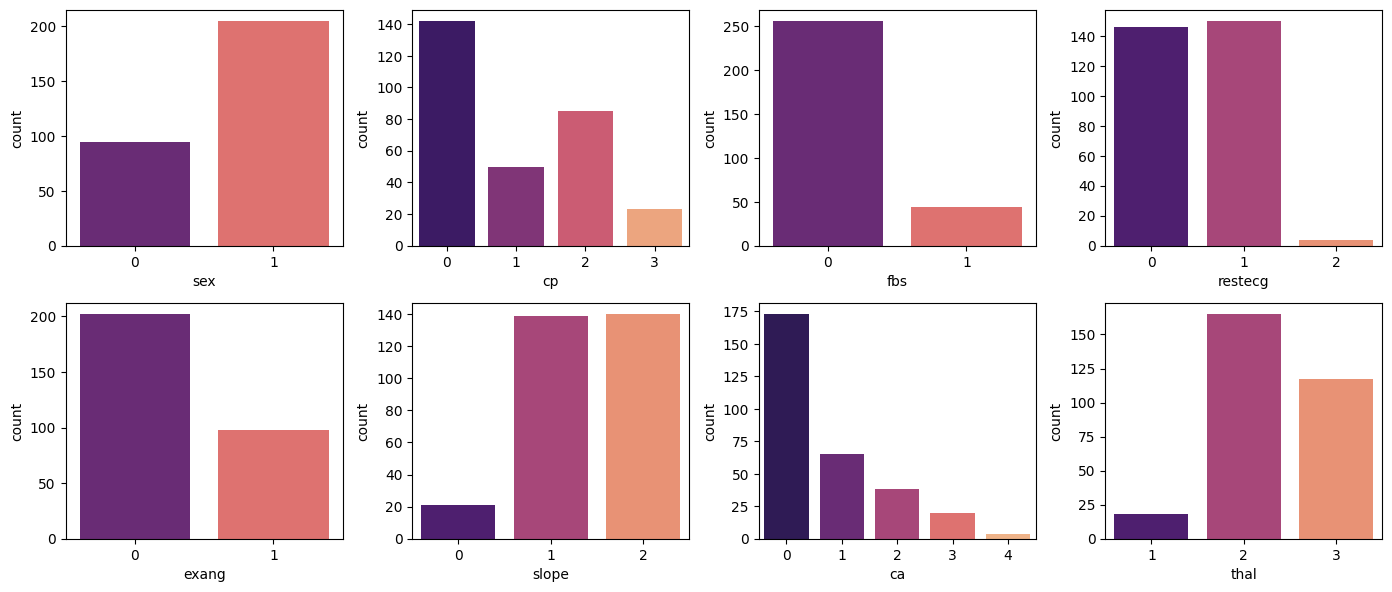

In [ ]:
plt.figure(figsize=(14,6))
for index, column in enumerate(categorical_col):
    plt.subplot(2, 4, index + 1)
    sns.countplot(data=categorical_col, x=column, palette = "magma")
    plt.xlabel(column)
    plt.ylabel("count")
plt.tight_layout(pad = 1.0)
plt.show()

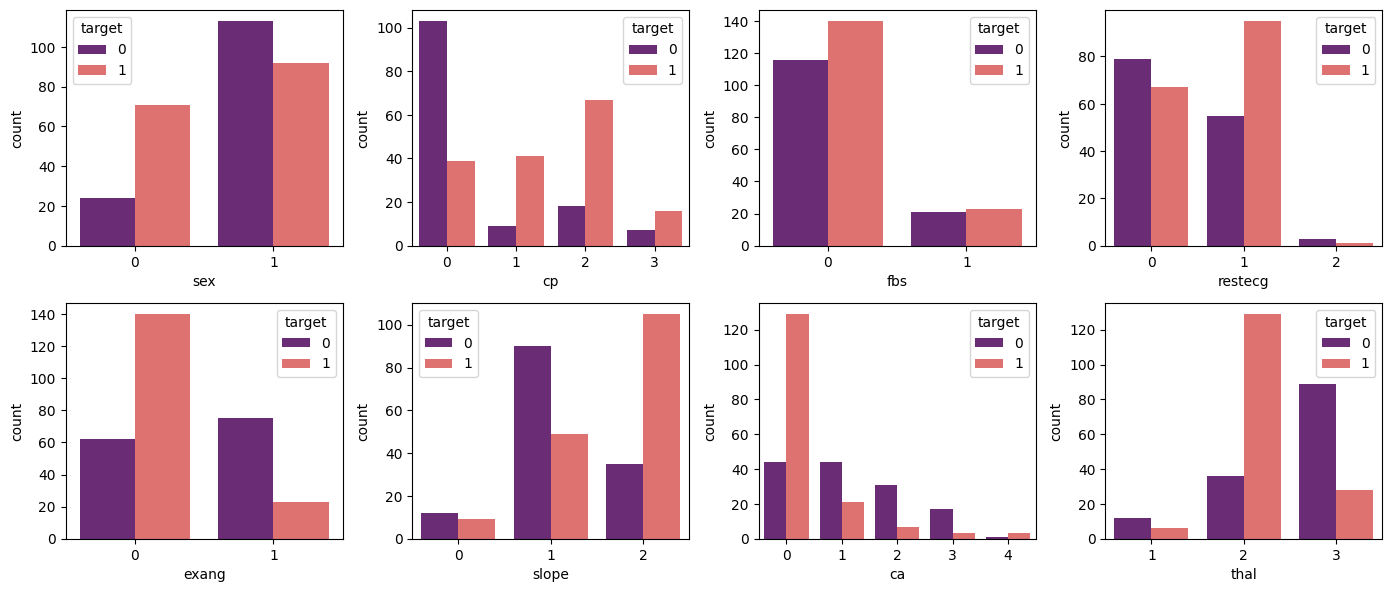

In [ ]:
plt.figure(figsize=(14,6))
for index in range(len(categorical_col.columns)):
  plt.subplot(2, 4, index + 1)
  sns.countplot(data=categorical_col, x=categorical_col.columns[index], hue=df['target'], palette = "magma")
  plt.xlabel(categorical_col.columns[index])
  plt.ylabel("count")
  plt.subplots_adjust(wspace = 0.3, hspace= 0.3)
plt.tight_layout(pad = 1.0)
plt.show()

* женщины чаще болеют
* люди с cp=0 болеют реже, с cp=1 и 2 чаще
* сильная связь болезни с restecg=1, exang=0, slope=2, ca=0, thal=2
* сильная обратная связь с exang=1, slope=1, ca=1,2,3, thal=3

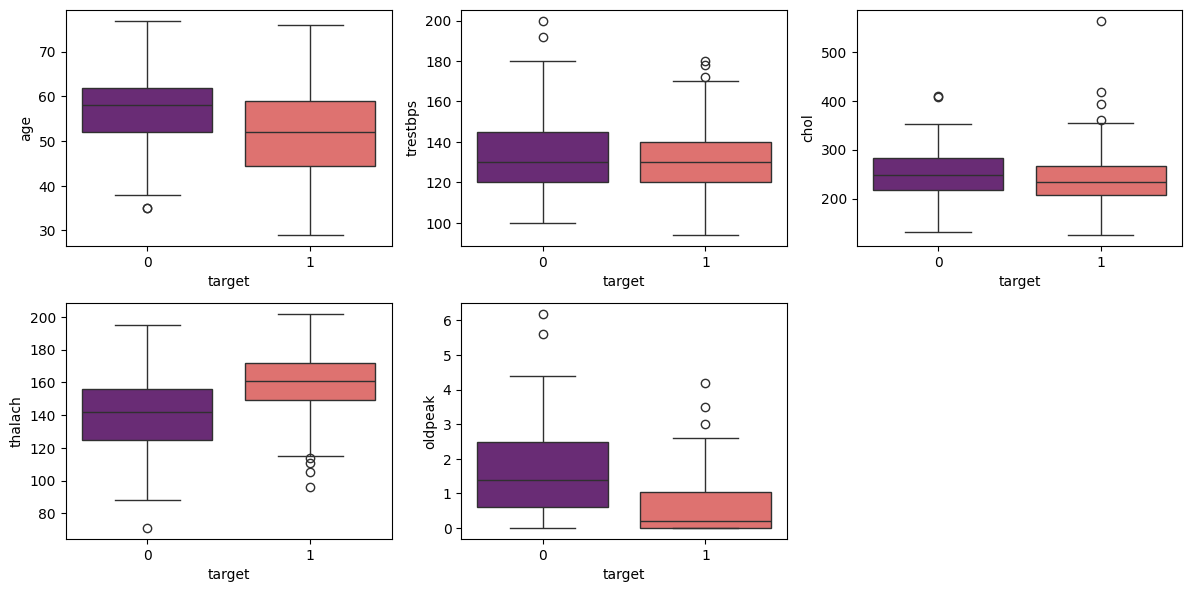

In [ ]:
plt.figure(figsize=(12,6))
for index in range(len(numerical_col.columns)):
  if numerical_col.columns[index] != 'target':
    plt.subplot(2, 3, index + 1)
    sns.boxplot(data=df, y=numerical_col.columns[index],x='target', palette = "magma")
    plt.xlabel('target')
    plt.ylabel(numerical_col.columns[index])
    plt.subplots_adjust(wspace = 0.3, hspace= 0.3)
plt.tight_layout(pad = 1.0)
plt.show()

* Среди более молодых людей больше болевших
* У больных выше thalach
* У больных ниже oldpeak

Преобразуем категориальные признаки

In [ ]:
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'ca', 'thal'], drop_first=True, dtype=float)
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,53,1,140,203,1,155,1,3.1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,70,1,145,174,0,125,1,2.6,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,61,1,148,203,0,161,0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,62,0,138,294,1,106,0,1.9,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Разобьём данные на тренировочную и тестовую выборки

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

Масштабируем признаки

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Подберём лучшие гиперпараметры с помощью GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    'lam': [0.01, 0.1, 1.0, 10.0]
}
random_search_my_lr = GridSearchCV(estimator=MyOwnLogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=2)
random_search_my_lr.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_my_lr.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_my_lr.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_my_lr.score(X_test_scaled, y_test))

Лучшие параметры: {'alpha': 0.01, 'lam': 10.0}
Наилучшая точность на обучающей выборке: 0.8285714285714286
Наилучшая точность на тестовой выборке: 0.8333333333333334


In [ ]:
param_grid = {
    'k': [1, 3, 5, 7, 9],
    'p': [1, 2, 'inf']
}
random_search_my_knn = GridSearchCV(estimator=MyOwnKNeighbors(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=2)
random_search_my_knn.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_my_knn.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_my_knn.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_my_knn.score(X_test_scaled, y_test))

Лучшие параметры: {'k': 7, 'p': 1}
Наилучшая точность на обучающей выборке: 0.8285714285714286
Наилучшая точность на тестовой выборке: 0.8


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [ ]:
param_grid = {
    'C': [1e-4, 1e-2, 1e-1, 1, 10, 100, 1000],
    'tol': [1e-4, 1e-3, 100, 1000]
}
random_search_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')
random_search_lr.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_lr.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_lr.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_lr.score(X_test_scaled, y_test))

Лучшие параметры: {'C': 0.1, 'tol': 0.0001}
Наилучшая точность на обучающей выборке: 0.8285714285714286
Наилучшая точность на тестовой выборке: 0.8333333333333334


In [ ]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'p': [1, 2, 'inf']
}
random_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
random_search_knn.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_knn.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_knn.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_knn.score(X_test_scaled, y_test))

Лучшие параметры: {'n_neighbors': 7, 'p': 1}
Наилучшая точность на обучающей выборке: 0.8285714285714286
Наилучшая точность на тестовой выборке: 0.8


In [ ]:
param_grid = {
    'C': [1e-4, 1e-2, 1e-1, 1, 10, 100, 1000],
    'tol': [1e-4, 1e-3, 100, 1000]
}
random_search_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, scoring='accuracy')
random_search_svc.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_svc.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_svc.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_svc.score(X_test_scaled, y_test))

Лучшие параметры: {'C': 0.1, 'tol': 0.0001}
Наилучшая точность на обучающей выборке: 0.8047619047619048
Наилучшая точность на тестовой выборке: 0.7888888888888889


In [ ]:
param_grid = {
    'priors': [[0.5, 0.5], [0.3, 0.7], [0.4, 0.6], [0.6, 0.4], [0.7, 0.3]],
    'var_smoothing': [1e-10, 1e-09, 1e-08, 1e-5, 1, 10]
}
random_search_gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
random_search_gnb.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_gnb.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_gnb.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_gnb.score(X_test_scaled, y_test))

Лучшие параметры: {'priors': [0.6, 0.4], 'var_smoothing': 1}
Наилучшая точность на обучающей выборке: 0.8476190476190476
Наилучшая точность на тестовой выборке: 0.7888888888888889


In [ ]:
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
random_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
random_search_dt.fit(X_train, y_train)

print("Лучшие параметры:", random_search_dt.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_dt.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_dt.score(X_test, y_test))

Лучшие параметры: {'max_depth': 3, 'min_samples_split': 8}
Наилучшая точность на обучающей выборке: 0.7809523809523811
Наилучшая точность на тестовой выборке: 0.7333333333333333


Построим confusion matrices

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Predictions
y_pred_my_lr = random_search_my_lr.predict(X_test_scaled)
y_pred_my_knn = random_search_my_knn.predict(X_test_scaled)
y_pred_lr = random_search_lr.predict(X_test_scaled)
y_pred_knn = random_search_knn.predict(X_test_scaled)
y_pred_svm = random_search_svc.predict(X_test_scaled)
y_pred_nb = random_search_gnb.predict(X_test_scaled)
y_pred_dt = random_search_dt.predict(X_test)

# Confusion Matrices
cm_my_lr = confusion_matrix(y_test, y_pred_my_lr)
cm_my_knn = confusion_matrix(y_test, y_pred_my_knn)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_dt = confusion_matrix(y_test, y_pred_dt)

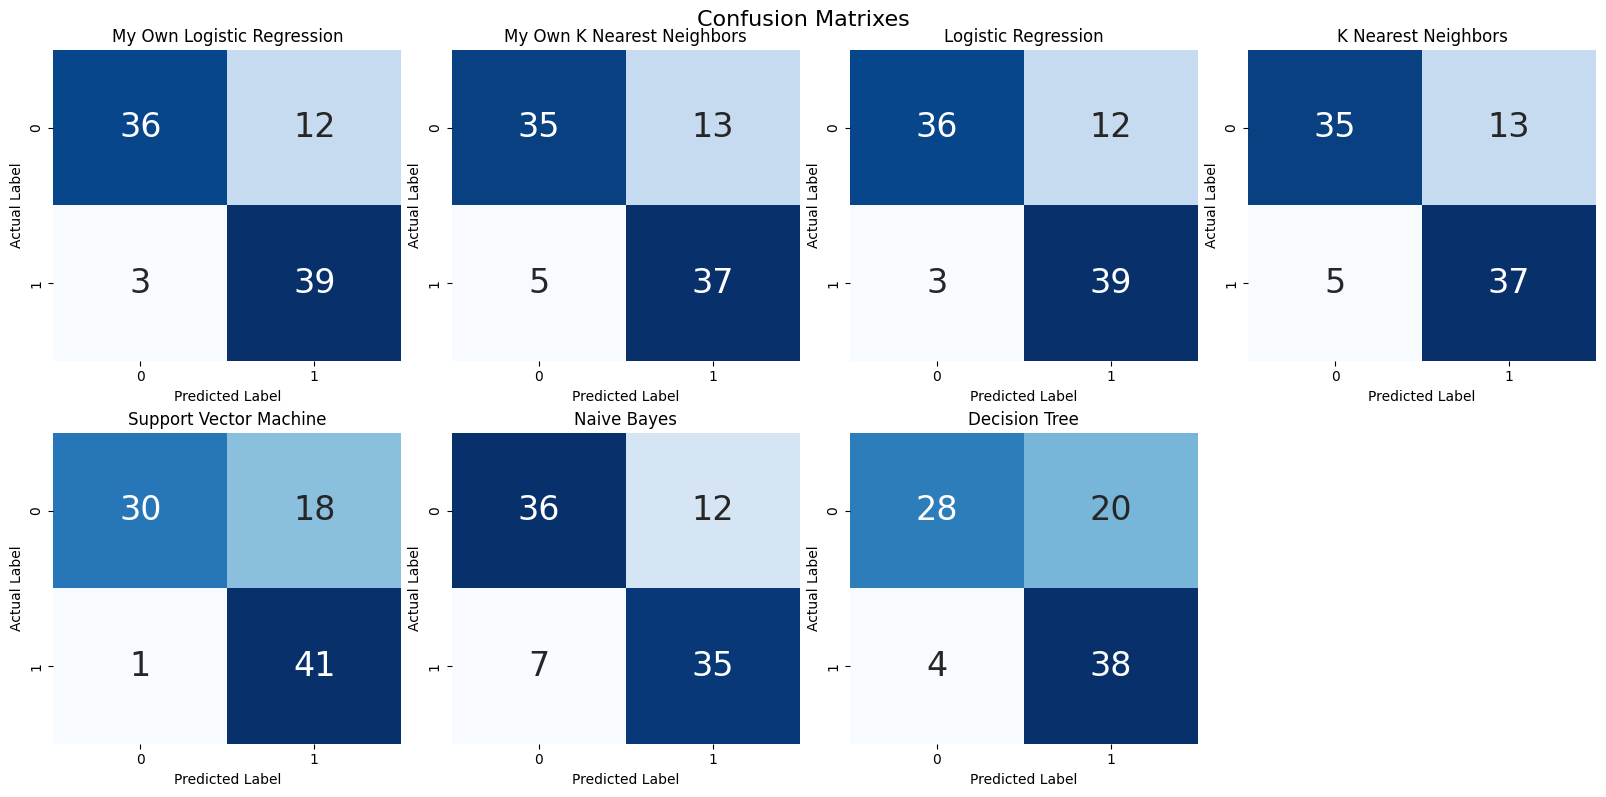

In [ ]:
plt.figure(figsize=(16, 8))

plt.suptitle("Confusion Matrixes", fontsize=16)


plt.subplot(2,4,1)
plt.title("My Own Logistic Regression", size=12)
sns.heatmap(cm_my_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,2)
plt.title("My Own K Nearest Neighbors", size=12)
sns.heatmap(cm_my_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,3)
plt.title("Logistic Regression", size=12)
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,4)
plt.title("K Nearest Neighbors", size=12)
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,5)
plt.title("Support Vector Machine", size=12)
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,6)
plt.title("Naive Bayes", size=12)
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,7)
plt.title("Decision Tree", size=12)
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.tight_layout(pad = 0.5)
plt.show()

Выводы:
* Результаты моих моделей совпадают с библиотечными
* У логистической регрессии лучший accuracy
* У SVM выше recall, но ниже precision


# Loan Approval

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

* person_age $-$	Age of the person
* person_gender	$-$ Gender of the person
* person_education $-$ Highest education level
* person_income	$-$ Annual income
* person_emp_exp $-$ Years of employment experience
* person_home_ownership $-$	Home ownership status (e.g., rent, own, mortgage)
* loan_amnt	$-$ Loan amount requested
* loan_intent $-$	Purpose of the loan
* loan_int_rate $-$	Loan interest rate
* loan_percent_income $-$	Loan amount as a percentage of annual income
* cb_person_cred_hist_length $-$	Length of credit history in years
* credit_score $-$	Credit score of the person
* previous_loan_defaults_on_file $-$	Indicator of previous loan defaults
* loan_status (**target**)	$-$ Loan approval status: 1 = approved; 0 = rejected

In [ ]:
df = pd.read_csv('/content/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [ ]:
df[df.duplicated()]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status


In [ ]:
pd.set_option('display.max_columns', 40)
%precision %8.8g
# df = df.round(decimals=0)
df.describe().apply(lambda s: s.apply(lambda x: format(x, '.7g')))

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000,45000,45000,45000,45000,45000,45000,45000,45000
mean,27.76418,80319.05,5.410333,9583.158,11.00661,0.1397249,5.867489,632.6088,0.2222222
std,6.045108,80422.5,6.063532,6314.887,2.978808,0.08721231,3.879702,50.43587,0.4157443
min,20,8000,0,500,5.42,0,2,390,0
25%,24,47204,1,5000,8.59,0.07,3,601,0
50%,26,67048,4,8000,11.01,0.12,4,640,0
75%,30,95789.25,8,12237.25,12.99,0.19,8,670,0
max,144,7200766,125,35000,20,0.66,30,850,1


Удалим выбросы

In [ ]:
cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_int_rate', 'loan_amnt','loan_percent_income', 'cb_person_cred_hist_length']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

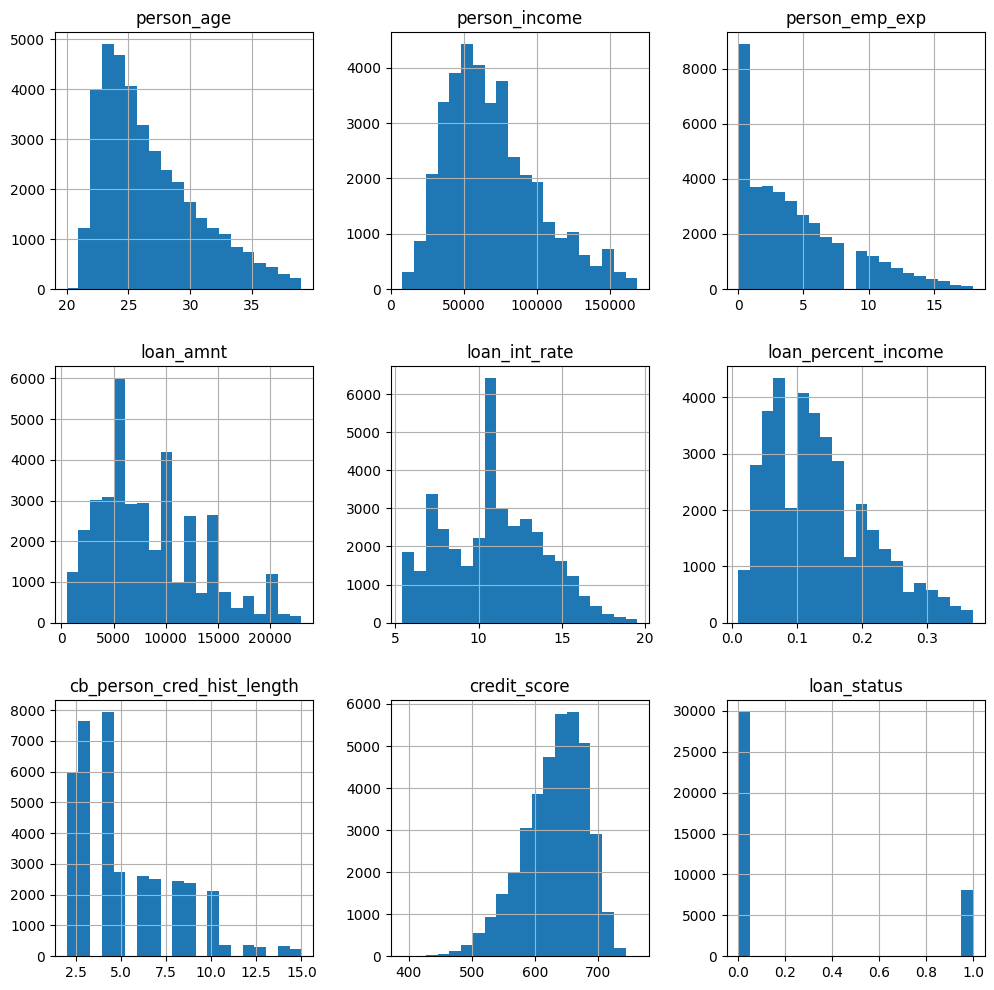

In [ ]:
df.hist(bins = 20, figsize = (12,12))
plt.show()

In [ ]:
numerical_col = df.select_dtypes(exclude=np.object_)
categorical_col = df.select_dtypes(exclude=np.number)

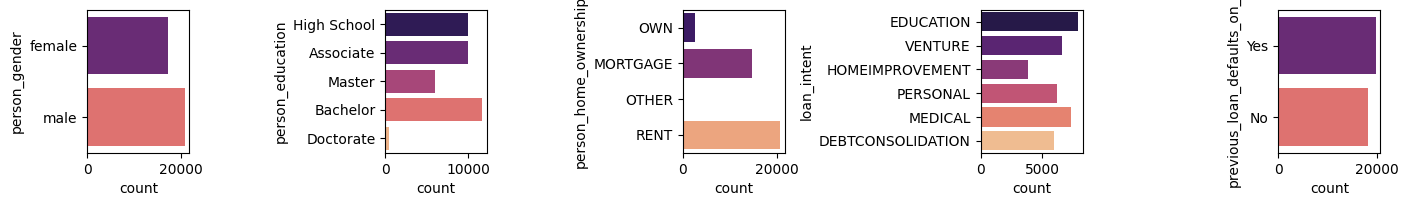

In [ ]:
plt.figure(figsize=(14,2))
for index, column in enumerate(categorical_col):
    plt.subplot(1, 5, index + 1)
    sns.countplot(data=categorical_col, y=column, palette = "magma")
    plt.ylabel(column)
plt.tight_layout(pad = 0.5)
plt.show()

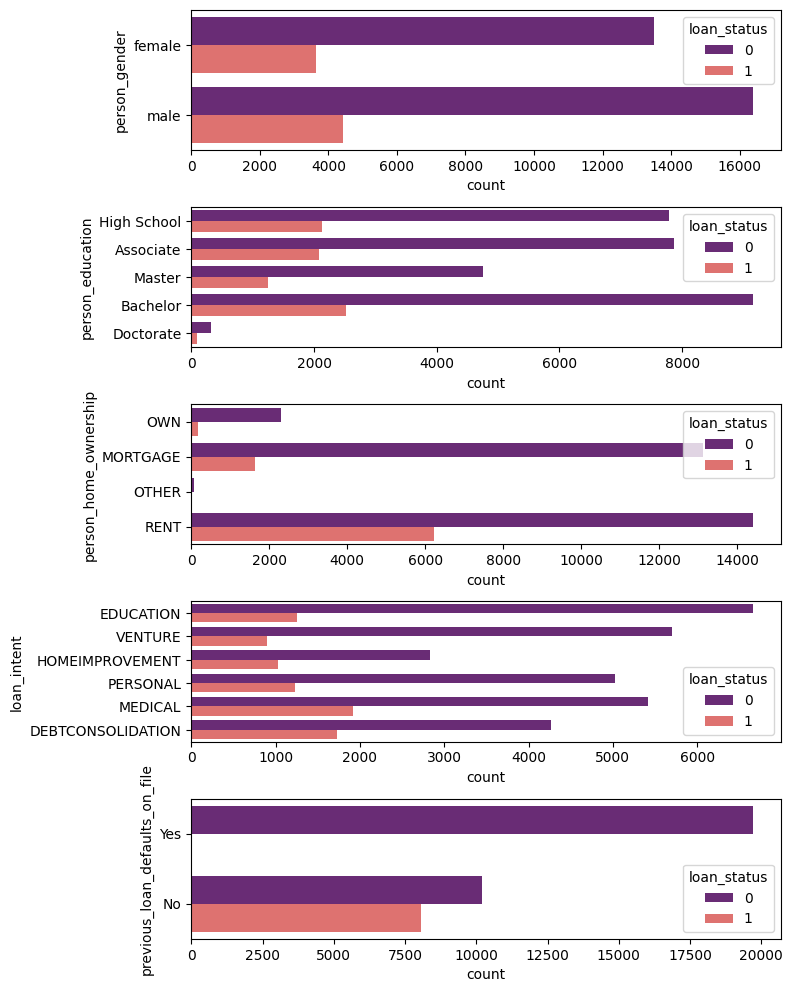

In [ ]:
plt.figure(figsize=(8, 10))
for index in range(len(categorical_col.columns)):
  plt.subplot(5, 1, index + 1)
  sns.countplot(data=categorical_col, y=categorical_col.columns[index], hue=df['loan_status'], palette = "magma")
  plt.ylabel(categorical_col.columns[index])
  plt.subplots_adjust(wspace = 0.3, hspace= 0.3)
plt.tight_layout(pad = 1.0)
plt.show()



*   Людям, снимающим жильё, чаще одобряют кредит, чем домовладельцам и тем, у кого ипотека
*   На лечение, ремонт и консолидацию долга чаще одобряют кредит
*   Людям, имевшим дефолты по кредитам, новый не одобрят



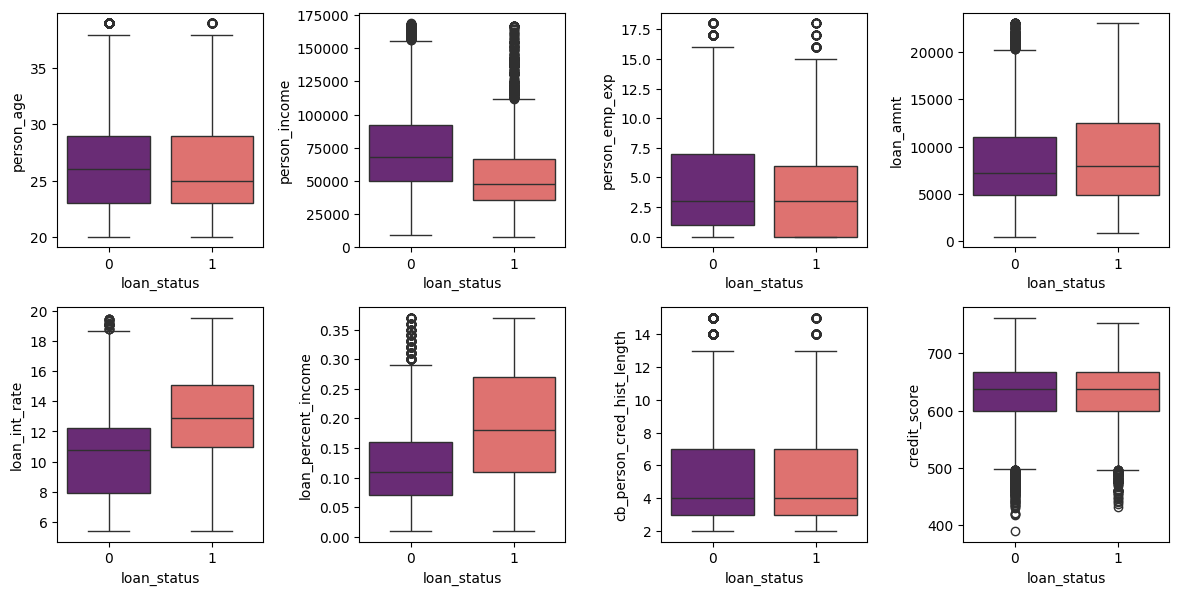

In [ ]:
plt.figure(figsize=(12,6))
for index in range(len(numerical_col.columns)):
  if numerical_col.columns[index] != 'loan_status':
    plt.subplot(2, 4, index + 1)
    sns.boxplot(data=df, y=numerical_col.columns[index],x='loan_status', palette = "magma")
    plt.xlabel('loan_status')
    plt.ylabel(numerical_col.columns[index])
    plt.subplots_adjust(wspace = 0.3, hspace= 0.3)
plt.tight_layout(pad = 1.0)
plt.show()



*   Чаще одобряют людям с более низким доходом
*   Чаще одобряют людям с меньшим трудовым стажем
*   Чаще одобряют кредиты с высокой процентной ставкой
*   Чаще одобряют кредиты, занимающие большую долю от дохода заёмщика



Преобразуем категориальные признаки

In [ ]:
df = pd.get_dummies(df, columns=['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'], drop_first=True, dtype=float)
df.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,person_education_Bachelor,person_education_Doctorate,person_education_High School,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,21.0,12951.0,0,2500.0,7.14,0.19,2.0,532,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,21.0,12739.0,0,1600.0,14.74,0.13,3.0,640,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,21.0,13113.0,0,4500.0,8.63,0.34,2.0,651,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19,24.0,14283.0,1,1750.0,10.99,0.12,2.0,679,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Разобьём данные на тренировочную и тестовую выборки

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['loan_status']
X = df.drop(columns=['loan_status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

Масштабируем признаки

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Подберём лучшие гиперпараметры с помощью RandomizedSearchCV, потому что датасет большой

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {
    'alpha': [0.1, 0.01, 0.001],
    'lam': [0.1, 1.0, 10.0]
}
random_search_my_lr = RandomizedSearchCV(estimator=MyOwnLogisticRegression(), param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy', verbose=10)
random_search_my_lr.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_my_lr.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_my_lr.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_my_lr.score(X_test_scaled, y_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START alpha=0.1, lam=1.0..........................................
[CV 1/5; 1/5] END ...........alpha=0.1, lam=1.0;, score=0.793 total time=  26.6s
[CV 2/5; 1/5] START alpha=0.1, lam=1.0..........................................
[CV 2/5; 1/5] END ...........alpha=0.1, lam=1.0;, score=0.799 total time=  26.6s
[CV 3/5; 1/5] START alpha=0.1, lam=1.0..........................................
[CV 3/5; 1/5] END ...........alpha=0.1, lam=1.0;, score=0.795 total time=  27.7s
[CV 4/5; 1/5] START alpha=0.1, lam=1.0..........................................
[CV 4/5; 1/5] END ...........alpha=0.1, lam=1.0;, score=0.796 total time=  27.6s
[CV 5/5; 1/5] START alpha=0.1, lam=1.0..........................................
[CV 5/5; 1/5] END ...........alpha=0.1, lam=1.0;, score=0.797 total time=  27.9s
[CV 1/5; 2/5] START alpha=0.01, lam=1.0.........................................
[CV 1/5; 2/5] END ..........alpha=0.01, lam=1.0;,

In [ ]:
param_grid = {
    'k': [3, 5, 7, 9],
    'p': [1, 2]
}
random_search_my_knn = RandomizedSearchCV(estimator=MyOwnKNeighbors(), param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy', verbose=10)
random_search_my_knn.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_my_knn.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_my_knn.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_my_knn.score(X_test_scaled, y_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START k=3, p=2....................................................
[CV 1/5; 1/5] END .....................k=3, p=2;, score=0.876 total time=  16.8s
[CV 2/5; 1/5] START k=3, p=2....................................................
[CV 2/5; 1/5] END .....................k=3, p=2;, score=0.876 total time=  13.8s
[CV 3/5; 1/5] START k=3, p=2....................................................
[CV 3/5; 1/5] END .....................k=3, p=2;, score=0.882 total time=  13.0s
[CV 4/5; 1/5] START k=3, p=2....................................................
[CV 4/5; 1/5] END .....................k=3, p=2;, score=0.885 total time=  13.0s
[CV 5/5; 1/5] START k=3, p=2....................................................
[CV 5/5; 1/5] END .....................k=3, p=2;, score=0.877 total time=  13.0s
[CV 1/5; 2/5] START k=9, p=1....................................................
[CV 1/5; 2/5] END .....................k=9, p=1;,

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [ ]:
param_grid = {
    'C': [1e-4, 1e-2, 1e-1, 1, 10, 100, 1000],
    'tol': [1e-4, 1e-3, 100, 1000]
}
random_search_lr = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy')
random_search_lr.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_lr.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_lr.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_lr.score(X_test_scaled, y_test))

Лучшие параметры: {'tol': 0.0001, 'C': 0.1}
Наилучшая точность на обучающей выборке: 0.8954338712729182
Наилучшая точность на тестовой выборке: 0.9005883902696057


In [ ]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'p': [1, 2]
}
random_search_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy')
random_search_knn.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_knn.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_knn.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_knn.score(X_test_scaled, y_test))

Лучшие параметры: {'p': 1, 'n_neighbors': 9}
Наилучшая точность на обучающей выборке: 0.8927240835833397
Наилучшая точность на тестовой выборке: 0.8992710986212348


In [ ]:
param_grid = {
    'C': [1e-4, 1e-2, 1e-1, 1, 10, 100, 1000],
    'tol': [1e-4, 1e-3, 100, 1000]
}
random_search_svc = RandomizedSearchCV(estimator=SVC(), param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy')
random_search_svc.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_svc.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_svc.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_svc.score(X_test_scaled, y_test))

Лучшие параметры: {'tol': 0.0001, 'C': 100}
Наилучшая точность на обучающей выборке: 0.9007792646990171
Наилучшая точность на тестовой выборке: 0.9055940985334153


In [ ]:
param_grid = {
    'priors': [[0.5, 0.5], [0.3, 0.7], [0.4, 0.6], [0.6, 0.4], [0.7, 0.3]],
    'var_smoothing': [1e-10, 1e-09, 1e-08, 1e-5, 1, 10]
}
random_search_gnb = RandomizedSearchCV(estimator=GaussianNB(), param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy')
random_search_gnb.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search_gnb.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_gnb.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_gnb.score(X_test_scaled, y_test))

Лучшие параметры: {'var_smoothing': 1, 'priors': [0.7, 0.3]}
Наилучшая точность на обучающей выборке: 0.8777428497331625
Наилучшая точность на тестовой выборке: 0.8863616404671995


In [ ]:
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
random_search_dt = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy')
random_search_dt.fit(X_train, y_train)

print("Лучшие параметры:", random_search_dt.best_params_)
print("Наилучшая точность на обучающей выборке:", random_search_dt.best_score_)
print("Наилучшая точность на тестовой выборке:", random_search_dt.score(X_test, y_test))

Лучшие параметры: {'min_samples_split': 2, 'max_depth': 9}
Наилучшая точность на обучающей выборке: 0.9150824689811123
Наилучшая точность на тестовой выборке: 0.9146395011855625


Построим confusion matrices

In [ ]:
# Predictions
y_pred_my_lr = random_search_my_lr.predict(X_test_scaled)
y_pred_my_knn = random_search_my_knn.predict(X_test_scaled)
y_pred_lr = random_search_lr.predict(X_test_scaled)
y_pred_knn = random_search_knn.predict(X_test_scaled)
y_pred_svm = random_search_svc.predict(X_test_scaled)
y_pred_nb = random_search_gnb.predict(X_test_scaled)
y_pred_dt = random_search_dt.predict(X_test)

# Confusion Matrices
cm_my_lr = confusion_matrix(y_test, y_pred_my_lr)
cm_my_knn = confusion_matrix(y_test, y_pred_my_knn)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_dt = confusion_matrix(y_test, y_pred_dt)

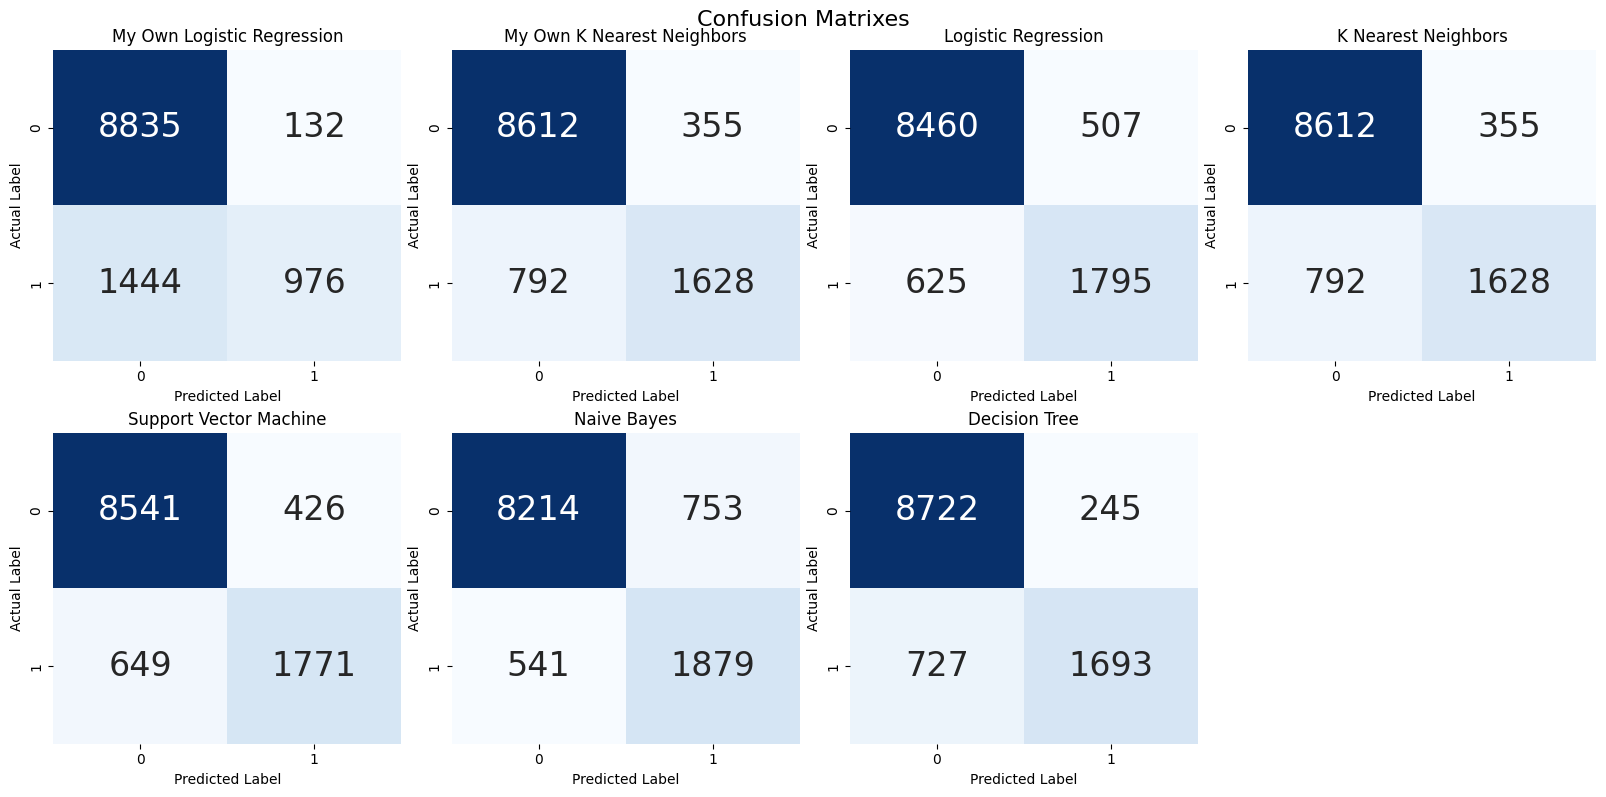

In [ ]:
plt.figure(figsize=(16, 8))

plt.suptitle("Confusion Matrixes", fontsize=16)


plt.subplot(2,4,1)
plt.title("My Own Logistic Regression", size=12)
sns.heatmap(cm_my_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,2)
plt.title("My Own K Nearest Neighbors", size=12)
sns.heatmap(cm_my_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,3)
plt.title("Logistic Regression", size=12)
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,4)
plt.title("K Nearest Neighbors", size=12)
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,5)
plt.title("Support Vector Machine", size=12)
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,6)
plt.title("Naive Bayes", size=12)
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(2,4,7)
plt.title("Decision Tree", size=12)
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.tight_layout(pad = 0.5)
plt.show()

Выводы:
* У моей реализации логистической регрессии лучший precision и вместе с тем худший recall и accuracy
* У decision tree лучший accuracy
* У наивного байесовского классификатора лучший recall
